# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "francois"
ln1 = "louguet"
fn2 = "pierre"
ln2 = "loviton"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_louguet_francois_and_loviton_pierre.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


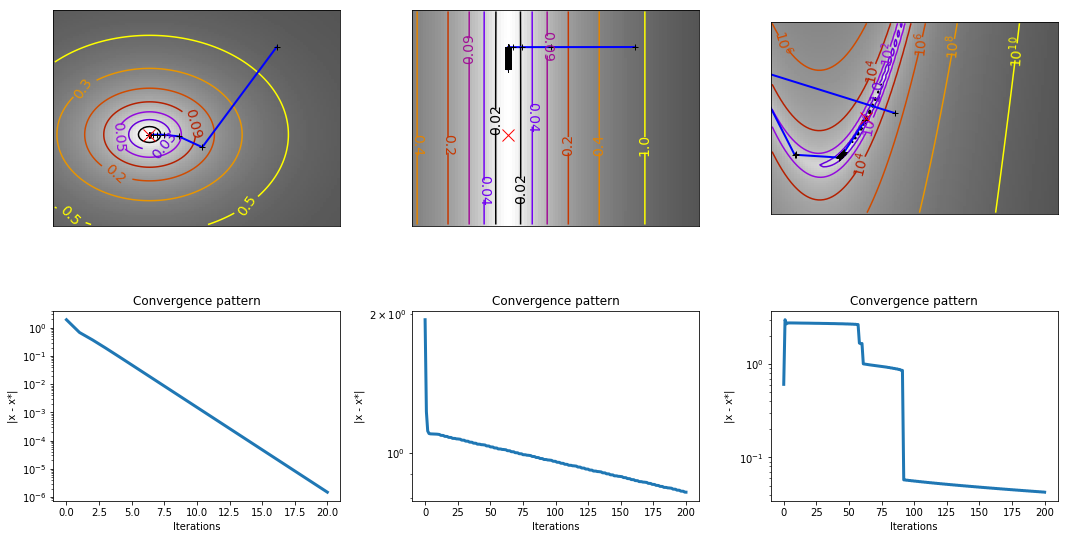

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [6]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO H = ..
        H = f_hessian(x)
        lambda_min = np.linalg.eigvals(H)[0]
        if lambda_min < lambda_threshold :
            H += (lambda_threshold - lambda_min) * np.eye(np.shape(H)[0])
        d = - np.linalg.solve(H,grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


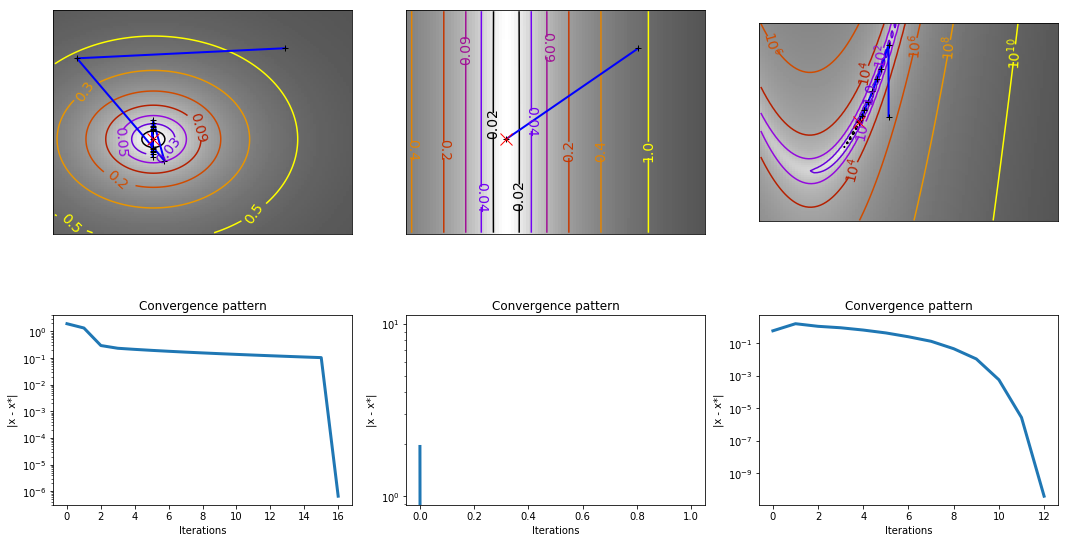

In [7]:
test_solver(newton)

WRITE YOUR COMMENTS HERE
1) Case 1 : The Newton method converges towards a minimum in 16 iterations against 20 for the GD algorithm. Even if this Gaussian function is not convex, the Newton method converges thanks to the regularization of the Hessian and the use of an optimal step size computed by line search.
2) Case 2 : The Newton method converges in 1 iteration because the function is quadratic. It is a result seen in course saying that for a quadratic function, regardless of the  conditionning (choice of x0), the Newton method converges in one iteration.
3) Case 3 : The Newton method converges towards a minimum in 12 iterations against 200 for the GD algorithm while the Rosenbrock function is a non-quadratic, non-convex and badly conditionned function. It is because the Newton method has a quadratic convergence while the gradient algorithm has a linear one.

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [11]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = ...
        corr_1 = np.outer(s, s.T) / (s.T @ y)
        corr_2 = - B @ np.outer(y, y.T) @ B / (y.T @ B @ y)
        B += (corr_1 + corr_2)
        
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


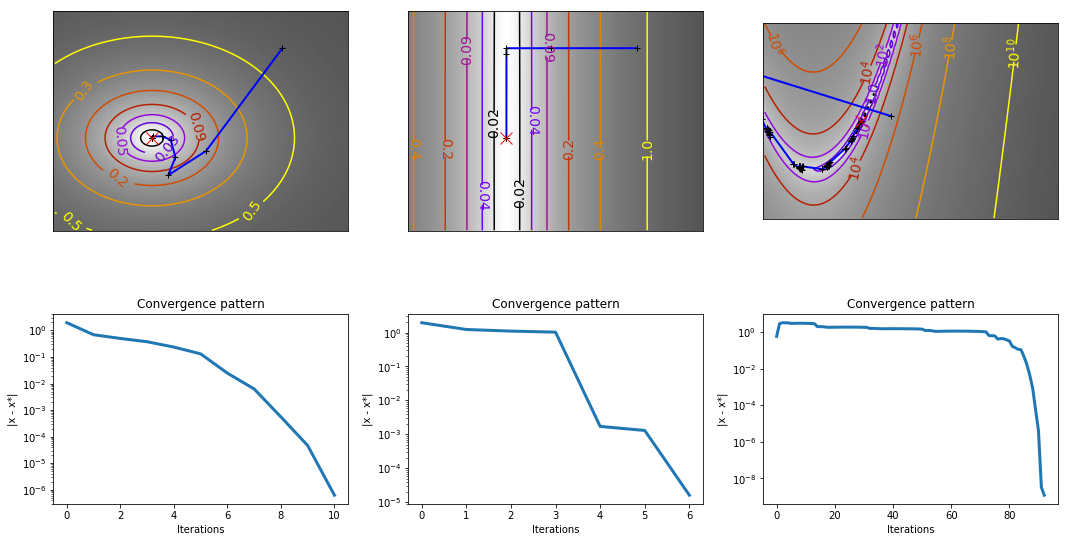

In [12]:
test_solver(dfp)

WRITE YOUR COMMENTS HERE

The DFP algorithm is a rank 2 correction on the inverse Hessian matrix.

1) Case 1 : DFP converges in 10 iterations which is faster than Newton on this convex example.
2) Case 2 : DFP converges in 6 iterations whereas according to the course, it is supposed to converge in 3 (size of x plus 1). It is because we are using line search to find the step size which is an  approximation not an exact optimal step.
3) Case 3 : DFP converges in 90 iterations against 12 for Newton. It is because the Rosenbrock global minimum is inside a long narrow parabolic flat valley. The Newton method finds the minimum faster because it uses the exact hessian matrix to find the optimal minimizing direction. DFP uses an approximation of the inverse hessian that might fail to fit the curvature of the rosenbrock curve. 

# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [13]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = 
        mu = 1 / (y.T @ s)
        V = np.eye(len(x)) - mu * np.outer(y, s.T)
        B = V.T @ B @ V + mu * np.outer(s, s.T)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


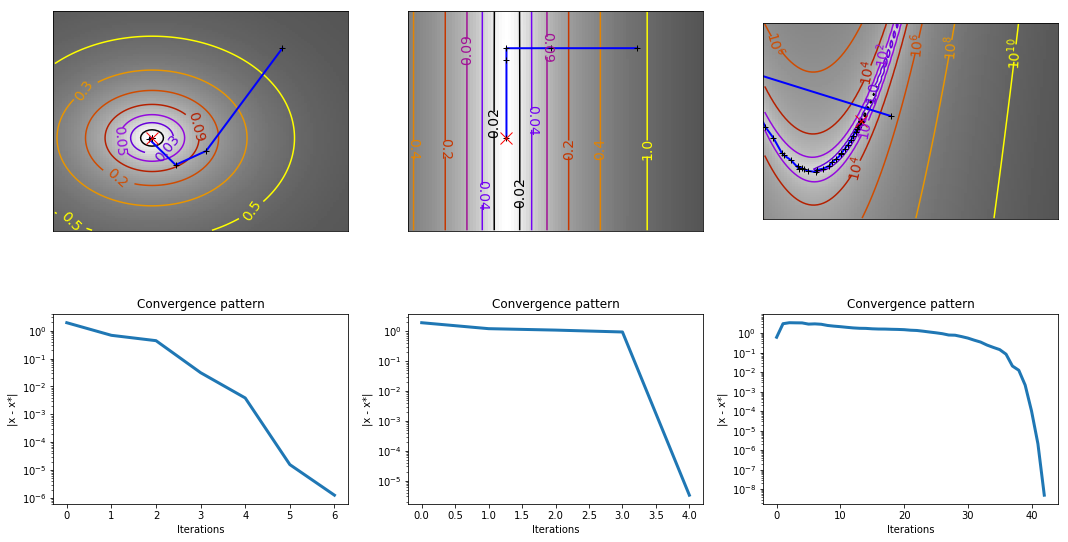

In [14]:
test_solver(bfgs)


We can observe that BFGS has the same pattern of convergence than DFP but is a little faster for the 3 cases. It is because BFGS is less sensitive than DFP on the inaccuracy of the line search method to find the optimal step.
For the case 2 of the quadratic function, the number of iterations has reduced but is still superior than 3.


# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [18]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    if len(mu_list) < m:
        m = len(mu_list)
    # TODO : first loop
    for i in reversed(range(m)):
        alpha = mu_list[i] * (s_list[i].T @ q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(m):
        beta = mu_list[i] * (y_list[i].T @ r)
        r += s_list[i] * (alpha_list[m-1-i] - beta)
    return -r

In [19]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


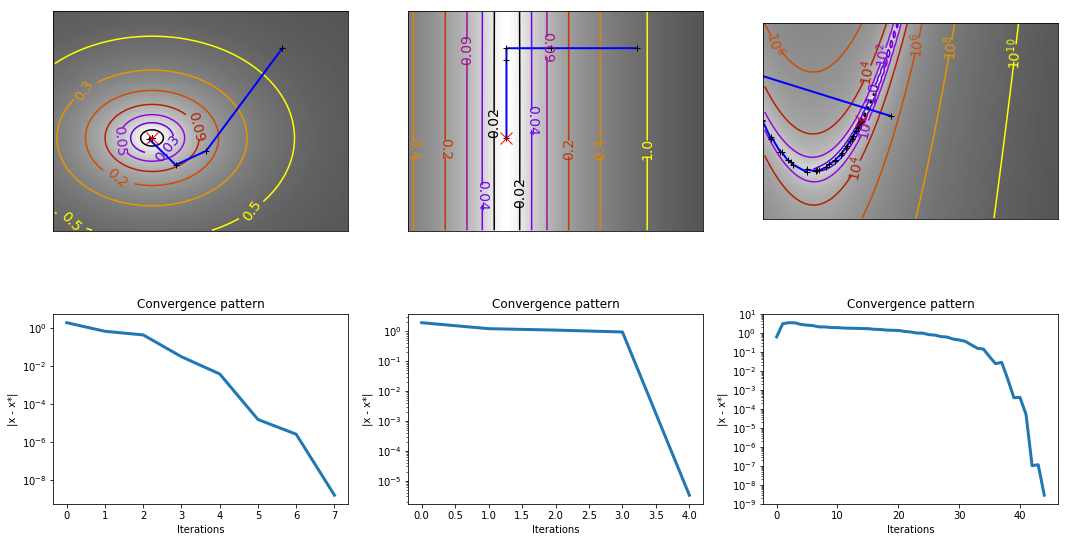

In [20]:
test_solver(lbfgs)

LBFGS is a derivative of BFGS that uses less memory because it does not store the full Hessian matrix in memory.
LBFGS does not perform better than BFGS in these cases because we are in dimension 2 and the use of the memory is not as important as it could be in bigger dimension.